<a href="https://colab.research.google.com/github/liao961120/cilin/blob/main/etc/naive_bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install -q CompoTree
!pip install -q cilin
!pip install -q opencc

     |████████████████████████████████| 766 kB 12.8 MB/s 


In [14]:
# Download font data
!wget 'https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKtc-hinted.zip'
!mkdir /tmp/fonts
!unzip -qo NotoSansCJKtc-hinted.zip -d /tmp/fonts/
!mv /tmp/fonts/NotoSansMonoCJKtc-Regular.otf /usr/share/fonts/truetype/NotoSansMonoCJKtc-Regular.otf -f
!rm -rf /tmp/fonts
!rm NotoSansCJKtc-hinted.zip

--2021-12-08 06:11:01--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKtc-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 173.194.79.128, 2a00:1450:4013:c05::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121247366 (116M) [application/zip]
Saving to: ‘NotoSansCJKtc-hinted.zip’

NotoSansCJKtc-hinte 100%[===================>] 115.63M  45.0MB/s    in 2.6s    

2021-12-08 06:11:05 (45.0 MB/s) - ‘NotoSansCJKtc-hinted.zip’ saved [121247366/121247366]



In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager  

# Set chinese font for plotting
font_dirs = ['/usr/share/fonts/truetype/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
  font_manager.fontManager.addfont(font_file)
plt.rcParams['font.family'] = "Noto Sans Mono CJK TC"

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import json
import numpy as np
import pandas as pd
from cilin import Cilin
from CompoTree import Radicals
from collections import Counter
from itertools import product, chain
from random import sample
from utils import *

C = Cilin(trad=True)
all_words = chain.from_iterable(C.category_split().values())
Tagger = RadicalSemanticTagger(all_words=all_words)
DTM = DocumentTermMatrix(RSTagger=Tagger, Cilin=C, level=3)

In [10]:
from sklearn.naive_bayes import MultinomialNB

df_feat, df_tgt = DTM.pd, DTM.df_tgt
X_train, X_test, y_train, y_test = train_test_split(
    df_feat, df_tgt, tgt_col="lev1", test_size = 0.3, random_state = 20
)

model = MultinomialNB(alpha=0.001)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print("Not predicted:", sorted(set(y_train) - set(predictions)))
classification_report(y_test, predictions)

Not predicted: ['F 動作', 'J 關聯', 'L 敬語']


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
A 人,0.739130,0.472222,0.576271,36.000000
B 物,0.536842,0.708333,0.610778,72.000000
C 時空,0.666667,0.111111,0.190476,18.000000
D 抽象事物,0.307692,0.230769,0.263736,52.000000
E 特徵,0.400000,0.629630,0.489209,54.000000
F 動作,0.000000,0.000000,0.000000,17.000000
G 心理活動,0.454545,0.384615,0.416667,13.000000
H 活動,0.414013,0.730337,0.528455,89.000000
I 現象與狀態,0.000000,0.000000,0.000000,39.000000
J 關聯,0.000000,0.000000,0.000000,13.000000


In [ ]:
np.exp(model.feature_log_prob_)

array([[4.11598565e-02, 4.96843623e-02, 4.41220427e-02, ...,
        2.79253631e-06, 2.79253631e-06, 2.79253631e-06],
       [2.24052083e-02, 1.20062276e-02, 1.23935791e-02, ...,
        1.41877072e-03, 3.30589601e-03, 1.10385101e-03],
       [5.52912494e-02, 1.88534058e-02, 9.86696419e-03, ...,
        1.38555735e-04, 5.36659960e-06, 5.36659960e-06],
       ...,
       [4.54475702e-02, 1.87442532e-02, 1.02691607e-02, ...,
        6.77140501e-06, 6.77140501e-06, 6.77140501e-06],
       [5.03904293e-02, 2.34591428e-02, 9.60889724e-03, ...,
        4.63322951e-06, 4.63322951e-06, 4.63322951e-06],
       [3.35862477e-02, 4.62446589e-03, 5.72065037e-05, ...,
        5.72065037e-05, 5.72065037e-05, 5.72065037e-05]])

## Heatmap

In [26]:
# Naive Bayes Posterior: P(X_i|y)
#mat = np.exp(model.feature_log_prob_).T
mat = model.feature_log_prob_.T
mat = pd.DataFrame(mat, index=DTM.features, columns=model.classes_)
mat

,A 人,B 物,C 時空,D 抽象事物,E 特徵,F 動作,G 心理活動,H 活動,I 現象與狀態,J 關聯,K 助語,L 敬語
NULL,-3.190292,-3.798459,-2.895119,-3.006377,-2.732782,-3.905965,-2.776600,-3.430227,-3.086186,-3.091204,-2.987964,-3.393694
人,-3.002062,-4.422329,-3.971022,-3.789926,-3.702263,-4.114290,-3.890355,-4.014028,-3.898670,-3.976885,-3.752510,-5.376605
人倫關係,-3.120789,-4.390576,-4.618533,-4.349922,-4.290063,-5.773573,-4.652828,-4.971341,-4.432598,-4.578636,-4.645063,-9.768849
人體內部,-5.774391,-5.336496,-7.602522,-5.517353,-5.845225,-8.027713,-5.423884,-6.220523,-5.649761,-6.330479,-7.048548,-9.768849
人體四肢,-3.481038,-3.604890,-3.937191,-3.518335,-3.162792,-2.348366,-3.464983,-3.220330,-3.189780,-3.122425,-3.301607,-3.382036
...,...,...,...,...,...,...,...,...,...,...,...,...
顏色_生活器物,-12.788561,-7.012589,-12.135321,-10.042439,-9.073782,-11.902189,-11.914972,-13.768579,-12.858076,-11.902826,-7.034315,-9.768849
顏色_禮樂,-12.788561,-13.410385,-12.135321,-8.234097,-13.247373,-11.902189,-11.914972,-8.297114,-12.858076,-11.902826,-12.282257,-9.768849
顏色_穿著器物,-12.788561,-6.558061,-8.884243,-8.038859,-7.329350,-11.902189,-11.914972,-7.714161,-7.094835,-11.902826,-12.282257,-9.768849
顏色_野獸,-12.788561,-5.712046,-12.135321,-9.049091,-13.247373,-11.902189,-11.914972,-13.768579,-12.858076,-11.902826,-12.282257,-9.768849


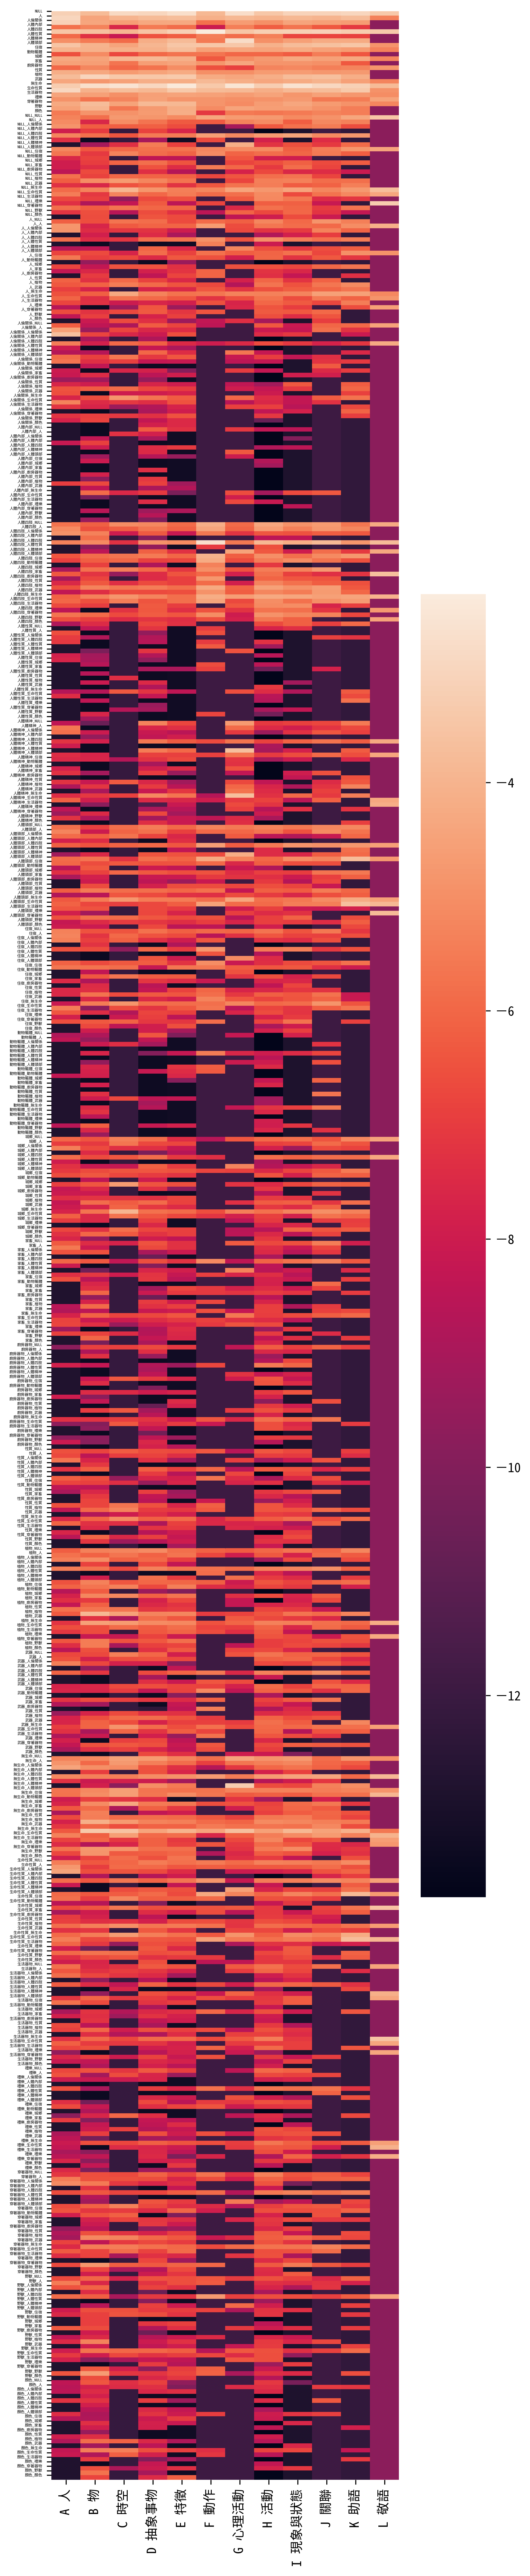

In [30]:
plt.figure(figsize=(6, 35), dpi=300)

ax = sns.heatmap(mat, xticklabels=True)
ax.set_yticks(range(mat.shape[0])) # <--- set the ticks first
ax.set_yticklabels(mat.index, fontsize=3)
plt.show()
# ax = sns.heatmap(tf_idf_mat.toarray(), linewidth=0.5)
# plt.imshow(mat, cmap='hot', interpolation='nearest')

In [40]:
# Tfidf matrix
DTM = DocumentTermMatrix(Tagger, C, level=1)
mat = pd.DataFrame(DTM.np.T, index=DTM.features, columns=DTM.df_tgt.lev1)
mat

lev1,A 人,B 物,C 時空,D 抽象事物,E 特徵,F 動作,G 心理活動,H 活動,I 現象與狀態,J 關聯,K 助語,L 敬語
NULL,0.357378,0.244946,0.438462,0.442960,0.476104,0.178882,0.444930,0.441260,0.433883,0.495022,0.519445,0.404172
人,0.372287,0.109401,0.131932,0.149378,0.151101,0.110339,0.135338,0.187616,0.150034,0.160201,0.221040,0.110229
人倫關係,0.236044,0.079750,0.057825,0.101248,0.068222,0.020062,0.046468,0.066611,0.134715,0.065683,0.064733,0.036743
人體內部,0.008498,0.019719,0.008489,0.015365,0.012508,0.001806,0.011292,0.012566,0.016058,0.012112,0.003410,0.000000
人體四肢,0.305200,0.237351,0.282951,0.278432,0.285192,0.662032,0.242214,0.506417,0.355036,0.384483,0.337876,0.477658
...,...,...,...,...,...,...,...,...,...,...,...,...
顏色_生活器物,0.000000,0.001813,0.000000,0.000328,0.000321,0.000000,0.000000,0.000516,0.000000,0.000000,0.002800,0.000000
顏色_禮樂,0.000000,0.002228,0.000000,0.000805,0.000000,0.000000,0.000000,0.001267,0.000000,0.000000,0.000000,0.000000
顏色_穿著器物,0.000615,0.003906,0.000834,0.001372,0.001344,0.000000,0.000000,0.000864,0.001339,0.000000,0.000000,0.000000
顏色_野獸,0.000902,0.011138,0.000000,0.000805,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


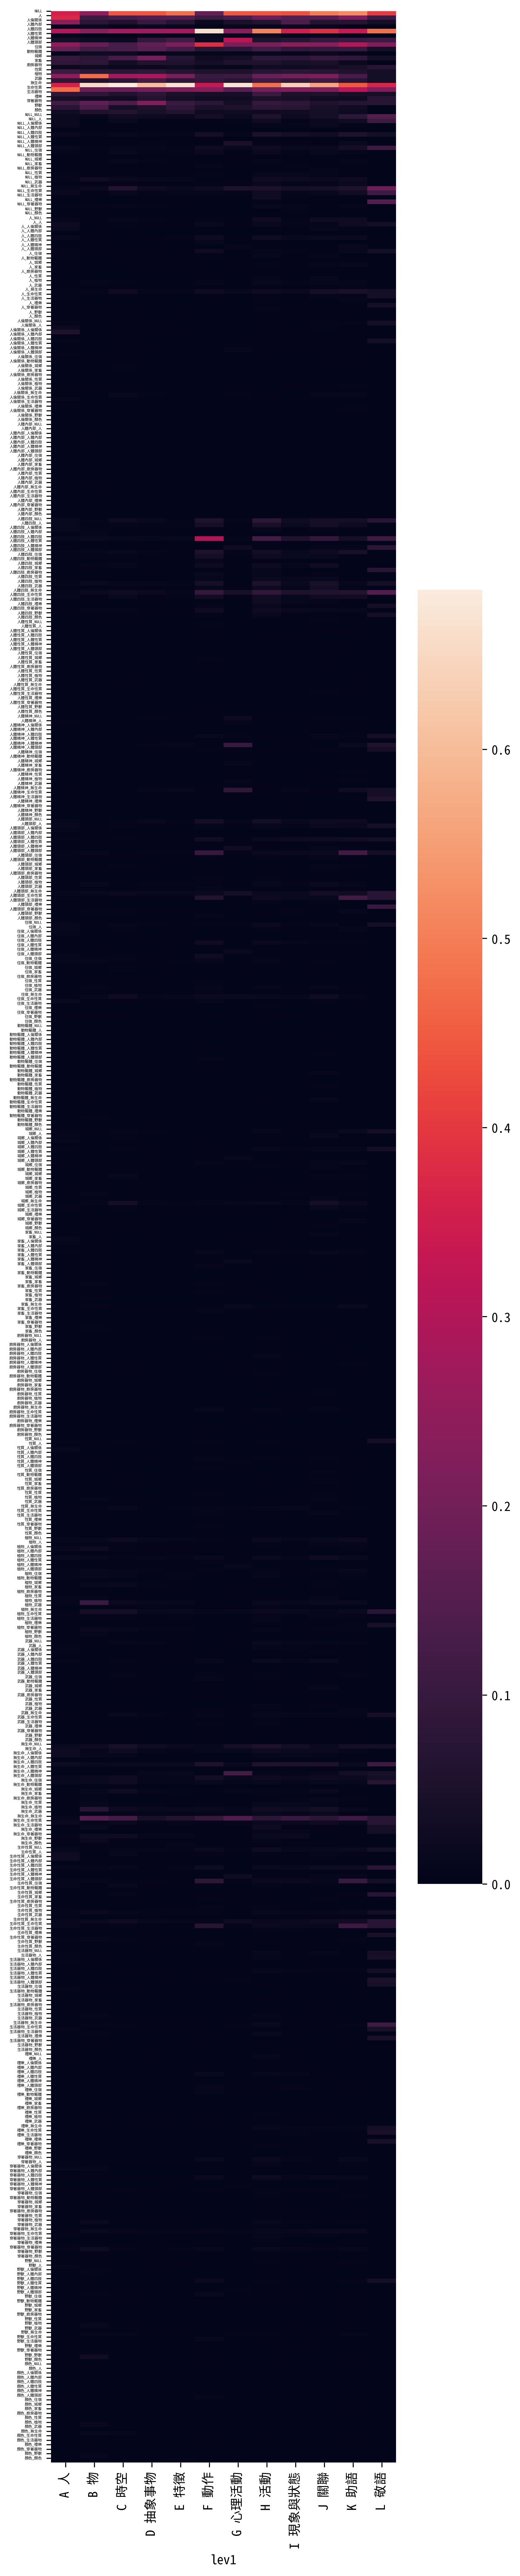

In [42]:
plt.figure(figsize=(6, 35), dpi=300)

ax = sns.heatmap(mat, xticklabels=True)
ax.set_yticks(range(mat.shape[0])) # <--- set the ticks first
ax.set_yticklabels(mat.index, fontsize=3)
plt.show()